In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from tqdm import tqdm

In [37]:
generator = nn.Sequential(
    nn.ConvTranspose2d(10, 1024, 4),
    nn.BatchNorm2d(1024),
    nn.ReLU(),
    nn.ConvTranspose2d(1024, 512, 4, 2),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.ConvTranspose2d(512, 256, 4, 2),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.ConvTranspose2d(256, 128, 4, 1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.ConvTranspose2d(128, 1, 4, 1),
    nn.Sigmoid(),
)

discriminator = nn.Sequential(
    nn.Conv2d(1, 16, 4, 2, 1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 8, 4, 2, 1),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.Conv2d(8, 4, 4, 2, 1),
    nn.BatchNorm2d(4),
    nn.ReLU(),
    nn.Conv2d(4, 1, 3),
    nn.Sigmoid(),
)

opt_g = torch.optim.Adam(generator.parameters())
opt_d = torch.optim.Adam(discriminator.parameters())

criterion = nn.BCELoss()

training_data = datasets.MNIST(
    root="/home/secondvoca/sdc_ae_23/data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

dataloader = DataLoader(training_data, batch_size=128, shuffle=True)

In [24]:
def train(generator, discriminator, opt_g, opt_d, criterion, dataloader, epochs, dim_latent):
    if torch.cuda.is_available():
        cuda_count = torch.cuda.device_count()

        no = 0
        mem_available = 0

        for i in range(cuda_count):
            tmp_available = torch.cuda.mem_get_info(i)[0]
            if mem_available < tmp_available:
                no = i
                mem_available = tmp_available
        device = f"cuda:{no}"
    else:
        device = "cpu"

    print(f"Now, it's working on {device}.")


    generator.to(device)
    discriminator.to(device)

    generator.train()
    discriminator.train()

    for _ in tqdm(range(epochs)):
        for x, _ in dataloader:

            batch_size = len(x)
            x = x.to(device)
            
            noise = torch.randn(batch_size, dim_latent, 1, 1, device=device)
            fake_data = generator(noise).detach()

            opt_d.zero_grad()
            
            prediction_real = discriminator(x).view(-1)
            error_real = criterion(prediction_real, torch.ones(batch_size, device=device))
            error_real.backward()

            prediction_fake = discriminator(fake_data).view(-1)
            error_fake = criterion(prediction_fake, torch.zeros(batch_size, device=device))
            
            error_fake.backward()
            opt_d.step()

            noise = torch.randn(batch_size, dim_latent, 1, 1, device=device)
            fake_data = generator(noise)

            opt_g.zero_grad()
            
            prediction = discriminator(fake_data).view(-1)
            error = criterion(prediction, torch.ones(batch_size, device=device))
            
            error.backward()
            opt_g.step()

    generator.to("cpu")
    discriminator.to("cpu")

    generator.eval()
    discriminator.eval()

In [28]:
train(generator, discriminator, opt_g, opt_d, criterion, dataloader, 10, 10)

Now, it's working on cuda:0.


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [02:08<00:00, 12.84s/it]


In [19]:
def test_generator(model, dim_latent):
    z = torch.randn(10, dim_latent, 1, 1)
    with torch.no_grad():
        imgs = model(z)
        print(imgs.shape)
        print(imgs.max().item(), imgs.min().item())
    _, axs = plt.subplots(1, 10, figsize=[20, 4])
    for img, ax in zip(imgs, axs):
        ax.imshow(img.view(28, 28), cmap="gray", vmax=1, vmin=0)
        ax.axis("off")
    plt.tight_layout()

torch.Size([10, 1, 28, 28])
1.0 0.0


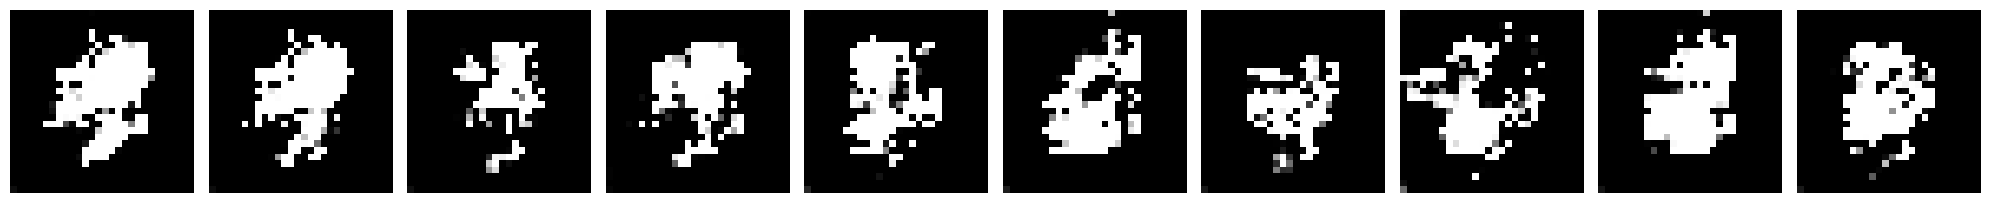

In [29]:
dim_latent = 10
test_generator(generator, dim_latent)

In [31]:
train(generator, discriminator, opt_g, opt_d, criterion, dataloader, 10, 100)

Now, it's working on cuda:0.


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [02:08<00:00, 12.86s/it]


torch.Size([10, 1, 28, 28])
1.0 0.0


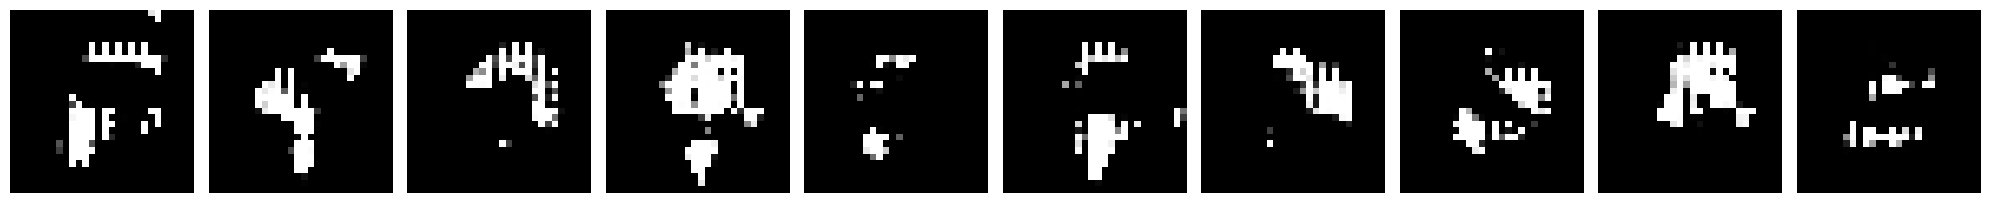

In [32]:
dim_latent = 100
test_generator(generator, dim_latent)

Now, it's working on cuda:0.


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [21:23<00:00, 12.84s/it]


torch.Size([10, 1, 28, 28])
1.0 3.3499024061726094e-37


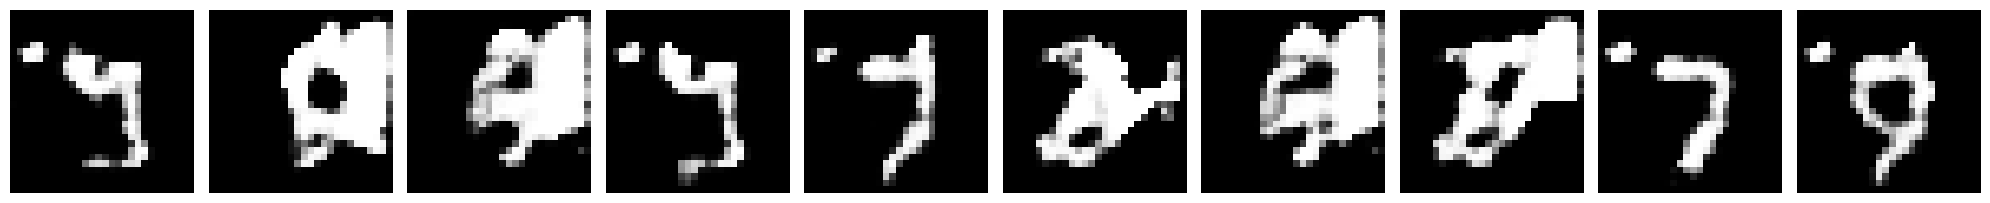

In [35]:
train(generator, discriminator, opt_g, opt_d, criterion, dataloader, 100, 10)
dim_latent = 10
test_generator(generator, dim_latent)

Now, it's working on cuda:0.


100%|██████████| 10/10 [02:43<00:00, 16.33s/it]


torch.Size([10, 1, 28, 28])
1.0 0.0


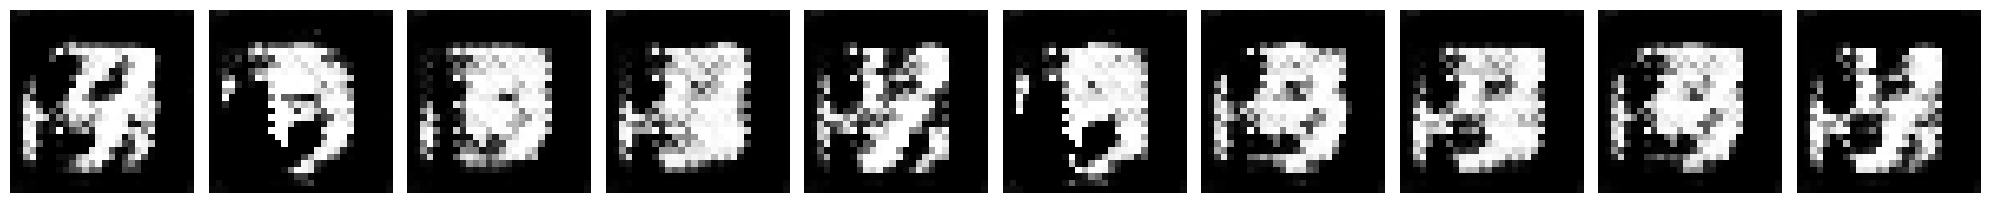

In [38]:
train(generator, discriminator, opt_g, opt_d, criterion, dataloader, 10, 10)
dim_latent = 10
test_generator(generator, dim_latent)